In [1]:
import numpy as np
import time
import Levenshtein as lev
import os
from annchor.datasets import load_strings


k=15

def levdist(a,b):
    return lev.distance(a,b)

strings_data = load_strings()
X = strings_data['X']
y = strings_data['y']
neighbor_graph = strings_data['neighbor_graph']

nx = X.shape[0]

for x in X[::100]:
    print(x[:50]+'...')

cuiojvfnseoksugfcbwzrcoxtjxrvojrguqttjpeauenefmkmv...
uiofnsosungdgrxiiprvojrgujfdttjioqunknefamhlkyihvx...
cxumzfltweskptzwnlgojkdxidrebonxcmxvbgxayoachwfcsy...
cmjpuuozflodwqvkascdyeosakdupdoeovnbgxpajotahpwaqc...
vzdiefjmblnumdjeetvbvhwgyasygrzhuckvpclnmtviobpzvy...
nziejmbmknuxdhjbgeyvwgasygrhcpdxcgnmtviubjvyzjemll...
yhdpczcjxirmebhfdueskkjjtbclvncxjrstxhqvtoyamaiyyb...
yfhwczcxakdtenvbfctugnkkkjbcvxcxjwfrgcstahaxyiooeb...
yoftbrcmmpngdfzrbyltahrfbtyowpdjrnqlnxncutdovbgabo...
tyoqbywjhdwzoufzrqyltahrefbdzyunpdypdynrmchutdvsbl...
dopgwqjiehqqhmprvhqmnlbpuwszjkjjbshqofaqeoejtcegjt...
rahobdixljmjfysmegdwyzyezulajkzloaxqnipgxhhbyoztzn...
dfgxsltkbpxvgqptghjnkaoofbwqqdnqlbbzjsqubtfwovkbsk...
pjwamicvegedmfetridbijgafupsgieffcwnmgmptjwnmwegvn...
ovitcihpokhyldkuvgahnqnmixsakzbmsipqympnxtucivgqyi...
xvepnposhktvmutozuhkbqarqsbxjrhxuumofmtyaaeesbeuhf...


In [2]:
from annchor import compare_neighbor_graphs


In [ ]:
from annchor import BruteForce

start_time = time.time()

bruteforce = BruteForce(X,levdist)
bruteforce.get_neighbor_graph()

print('Brute Force Time: %5.3f seconds' % (time.time()-start_time))

error = compare_neighbor_graphs(neighbor_graph,
                                bruteforce.neighbor_graph,
                                k)

print('Brute Force Accuracy: %d incorrect NN pairs (%5.3f%%)' % (error,100*error/(k*nx)))

In [ ]:
import nmslib

start_time = time.time()

# specify some parameters
CPU_COUNT = os.cpu_count()

index_time_params = {'M': 20,
                     'indexThreadQty': CPU_COUNT,
                     'efConstruction': 100,
                     'post' : 2}

# create the index
index = nmslib.init(method='hnsw',
                    space='leven',
                    dtype=nmslib.DistType.INT,
                    data_type=nmslib.DataType.OBJECT_AS_STRING)

index.addDataPointBatch(data=list(X))
index.createIndex(index_time_params,print_progress=True)

# query the index
res = index.knnQueryBatch(list(X), k=k, num_threads=CPU_COUNT)
hnsw_neighbor_graph = [np.array([x[0]for x in res]),np.array([x[1]for x in res])]
print('HNSW Time: %5.3f seconds' % (time.time()-start_time))


error = compare_neighbor_graphs(neighbor_graph,
                                hnsw_neighbor_graph,
                                k)

print('HNSW Accuracy: %d incorrect NN pairs (%5.3f%%)' % (error,100*error/(k*nx)))

In [3]:
from annchor import Annchor

start_time = time.time()
ann = Annchor(X,
              levdist,
              n_anchors=15,
              n_neighbors=k,
              min_prob=0.02,
              random_seed=1,
              n_samples=3000,
              partitions=3)

ann.fit()
print('ANNchor Time: %5.3f seconds' % (time.time()-start_time))


# Test accuracy
error = compare_neighbor_graphs(neighbor_graph,
                                ann.neighbor_graph,
                                k)
print('ANNchor Accuracy: %d incorrect NN pairs (%5.3f%%)' % (error,100*error/(k*nx)))

ANNchor Time: 30.606 seconds
ANNchor Accuracy: 7 incorrect NN pairs (0.029%)


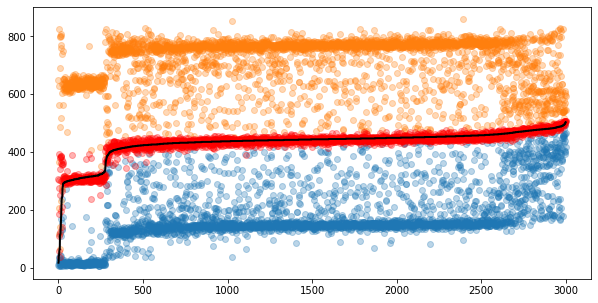

In [13]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(figsize=(10,5))
ax.plot(ann.G[np.argsort(ann.G[:,2]),:2],'o',alpha=0.3)
ax.plot(ann.LR.predict(ann.G[np.argsort(ann.G[:,2]),:2]),'ro',alpha=0.3)
ax.plot(ann.G[np.argsort(ann.G[:,2]),2],'-k',linewidth=2)




In [10]:
np.mean([len(x) for x in X])

498.225